In [2]:
import uproot
import h5py
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from scipy import optimize
from collections import defaultdict

In [3]:
def printattr(name, object):
    print(name)
h5py_file = h5py.File('h5files_w_klfitter/ttbar_testing_170_gev_with_spanet_KLFitter.h5', "r")
h5py_file.visititems(printattr)

jet_features
jet_features/barcode
jet_features/btag
jet_features/eta
jet_features/event
jet_features/mass
jet_features/num_of_jets
jet_features/phi
jet_features/pt
klfitter
klfitter/left_target
klfitter/left_target/b
klfitter/right_target
klfitter/right_target/b
klfitter/right_target/q1
klfitter/right_target/q2
klfitter/score
klfitter/score/event_probability
klfitter/score/loglikelihood
lepton_features
lepton_features/charge
lepton_features/eta
lepton_features/mass
lepton_features/phi
lepton_features/pid
lepton_features/pt
met_features
met_features/MET
met_features/eta
met_features/phi
met_features/sumet
neutrino_eta
neutrino_eta/spanet
neutrino_eta/target
parton_features
parton_features/eta
parton_features/masks
parton_features/mass
parton_features/parton_barcode
parton_features/pdgid
parton_features/phi
parton_features/pt
spanet
spanet/left_target
spanet/left_target/b
spanet/left_target/detection
spanet/left_target/mask
spanet/right_target
spanet/right_target/b
spanet/right_target/de

In [4]:
def get_reco_top_mass(h5py_file, target): # Target is spanet or klfitter
    dic = {}

    #Load pt, eta, phi, and mass from file.
    q1 = np.array([[i] for i in h5py_file[target + '/right_target/q1'][:]])
    dic['q1_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q1, axis=1).flatten()
    dic['q1_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q1, axis=1).flatten()
    dic['q1_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q1, axis=1).flatten()
    dic['q1_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q1, axis=1).flatten()

    q2 = np.array([[i] for i in h5py_file[target + '/right_target/q2'][:]])
    dic['q2_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q2, axis=1).flatten()
    dic['q2_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q2, axis=1).flatten()
    dic['q2_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q2, axis=1).flatten()
    dic['q2_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q2, axis=1).flatten()

    b = np.array([[i] for i in h5py_file[target + '/right_target/b'][:]])
    dic['b_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], b, axis=1).flatten()
    dic['b_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], b, axis=1).flatten()
    dic['b_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], b, axis=1).flatten()
    dic['b_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], b, axis=1).flatten()
    
    # px = pt*cos(phi)
    # py = pt*sin(phi)
    # pz = pt*sinh(eta)
    # E  = m**2 + px**2 + py**2 + pz**2
    dic['px1'] = dic['q1_pt']*np.cos(dic['q1_phi'])
    dic['py1'] = dic['q1_pt']*np.sin(dic['q1_phi'])
    dic['pz1'] = dic['q1_pt']*np.sinh(dic['q1_eta'])
    dic['E1'] = np.sqrt(dic['q1_mass']**2+dic['px1']**2+dic['py1']**2+dic['pz1']**2)

    dic['px2'] = dic['q2_pt']*np.cos(dic['q2_phi'])
    dic['py2'] = dic['q2_pt']*np.sin(dic['q2_phi'])
    dic['pz2'] = dic['q2_pt']*np.sinh(dic['q2_eta'])
    dic['E2'] = np.sqrt(dic['q2_mass']**2+dic['px2']**2+dic['py2']**2+dic['pz2']**2)

    dic['bx'] = dic['b_pt']*np.cos(dic['b_phi'])
    dic['by'] = dic['b_pt']*np.sin(dic['b_phi'])
    dic['bz'] = dic['b_pt']*np.sinh(dic['b_eta'])
    dic['bE'] = np.sqrt(dic['b_mass']**2+dic['bx']**2+dic['by']**2+dic['bz']**2)
    
    # M = sqrt((m1+m2)**2 + (px1+px2)**2 + (py1+py2)**2 + (pz1+pz2)**2)
    dic['reconstructed_top_mass'] = np.sqrt((dic['E1']+dic['E2']+dic['bE'])**2
                    - (dic['px1']+dic['px2']+dic['bx'])**2
                    - (dic['py1']+dic['py2']+dic['by'])**2
                    - (dic['pz1']+dic['pz2']+dic['bz'])**2)

    """
    cuts
    100 < reco_m_top < 300
    # 55 < reco_m_W < 110
    # 0.3 < reco_R_bq < 3.0
    """

    cut1 = np.logical_and(dic['reconstructed_top_mass'] > 100, dic['reconstructed_top_mass'] < 300)
    # cut2 = np.logical_and(dic['reconstructed_W_mass'] < 110, dic['reconstructed_W_mass'] > 55)
    # cut3 = np.logical_and(dic['reconstructed_R_bq'] < 3.0, dic['reconstructed_R_bq'] > 0.3)
    cuts = cut1

    # Check the state of the event.
    state = [1]*len(h5py_file['target/right_target/q1'][:])
    unmatch = np.logical_or.reduce((h5py_file['target/right_target/q1'][:] == -1,
                        h5py_file['target/right_target/q2'][:] == -1,
                        h5py_file['target/right_target/b'][:] == -1))
    state = np.where(unmatch, 0, state)

    # Two permutations for q1 and q2.
    a = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q1'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q2'][:])
    b = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q2'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q1'][:])
    a_or_b = np.logical_or(a, b)
    right = np.logical_and(a_or_b, h5py_file['target/right_target/b'][:] == h5py_file[target + '/right_target/b'][:])
    state = np.where(right, 2, state)    
    
    for key in dic: dic[key] = dic[key][cuts]
    state = state[cuts]

    return dic['reconstructed_top_mass'], state

In [5]:
# The reco_top_mss from ttbar_testing_mass_variation
mass = [170, 171, 172, 173, 174, 175, 176]
reco_spanet_dic = {}
reco_klf_dic = {}
state_spanet_dic = {} # 0 for unmatched, 1 for incorrect, 2 for correct
state_klf_dic = {}
state_labels = ['Unmatched', 'Incorrect', 'Correct']

for m in mass:
    h5py_file = h5py.File('h5files_w_klfitter/ttbar_testing_{}_gev_with_spanet_KLFitter.h5'.format(m), "r")
    reco_spanet_dic[m], state_spanet_dic[m] = get_reco_top_mass(h5py_file, 'spanet')
    reco_klf_dic[m], state_klf_dic[m] = get_reco_top_mass(h5py_file, 'klfitter')

In [6]:
# Fixed the bins, colors, and tot_event for all plots.
bins = np.arange(100, 301, 2)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
tot_event = 100000

In [7]:
h5py_file = h5py.File('ttbar_testing_sm/ttbar_testing_sm.h5'.format(m), "r")
reco_spanet, state_spanet = get_reco_top_mass(h5py_file, 'spanet')

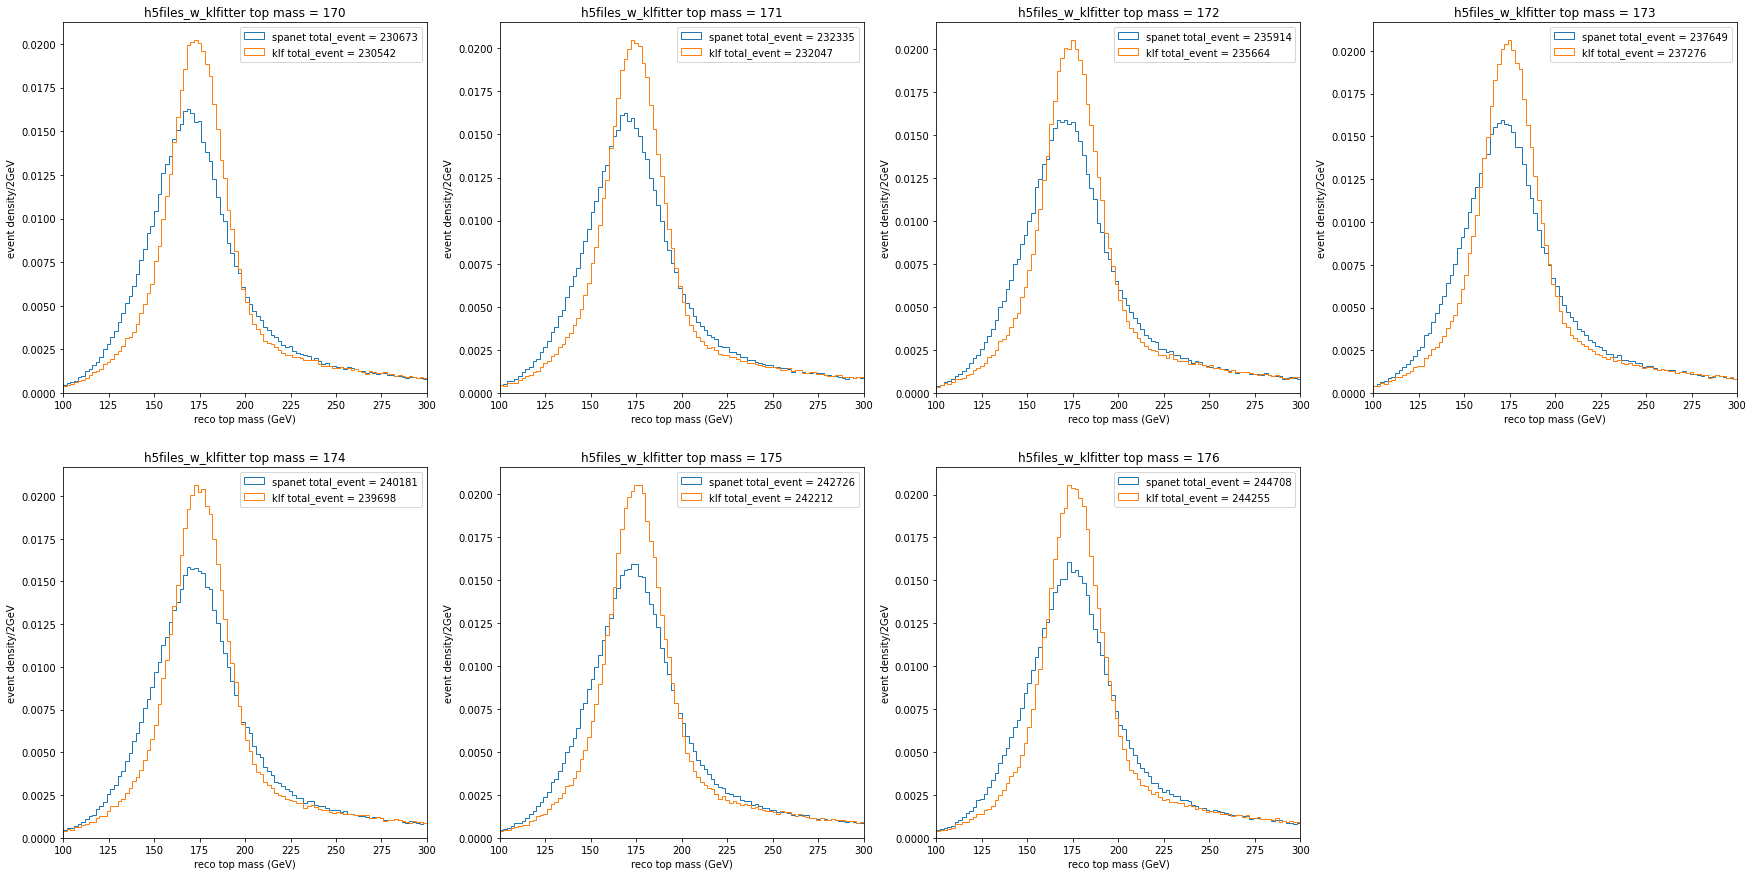

In [8]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    plt.hist(reco_spanet_dic[m], bins=bins, density=True, histtype='step', label='spanet total_event = ' + str(len(reco_spanet_dic[m])))
    plt.hist(reco_klf_dic[m], bins=bins, density=True, histtype='step', label='klf total_event = ' + str(len(reco_klf_dic[m])))
    plt.title('h5files_w_klfitter top mass = {}'.format(m))
    plt.xlim(100, 300)
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('event density/2GeV')
    plt.legend(loc='upper right')
plt.show()

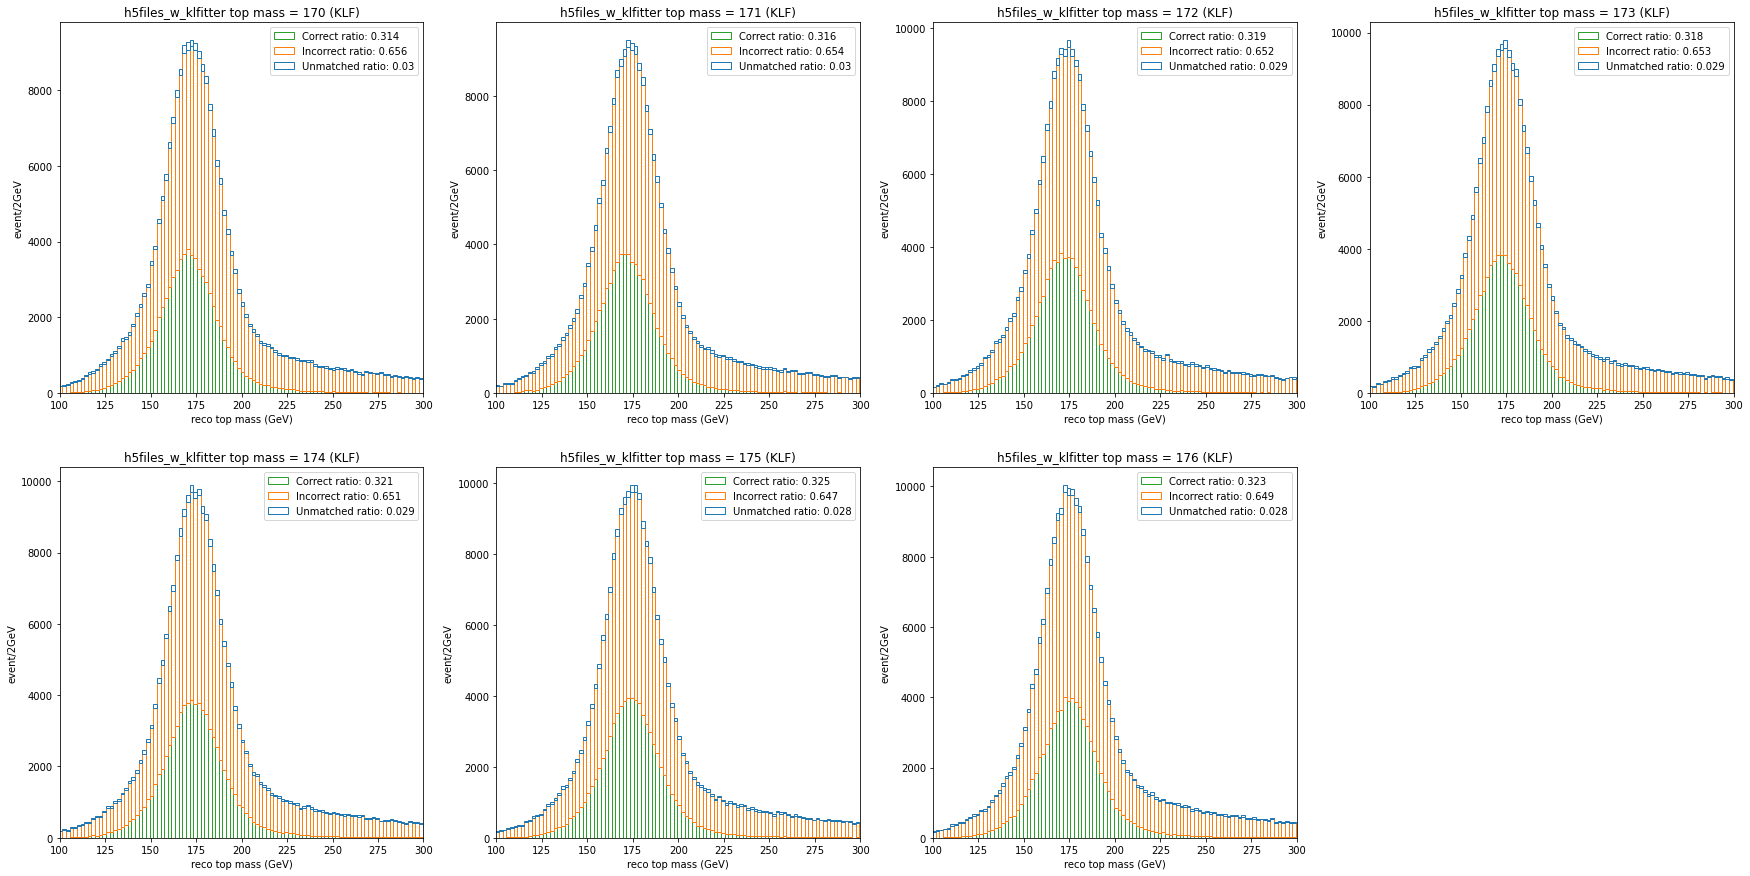

In [9]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    h = [0]*(len(bins)-1)
    
    for i in [2, 1, 0]:
        ratio = np.count_nonzero(state_klf_dic[m]==i)/len(state_klf_dic[m])
        hist, bin_edges = np.histogram(reco_klf_dic[m][state_klf_dic[m] == i], bins=bins)
        plt.bar(bin_edges[:-1]+0.5, hist, bottom=h, edgecolor=colors[i], width=2, color='None', label = state_labels[i] + ' ratio: ' + str(round(ratio, 3)))
        h += hist
    plt.title('h5files_w_klfitter top mass = {} (KLF)'.format(m))
    plt.xlim(100, 300)
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('event/2GeV')
    plt.legend(loc='upper right')
plt.show()

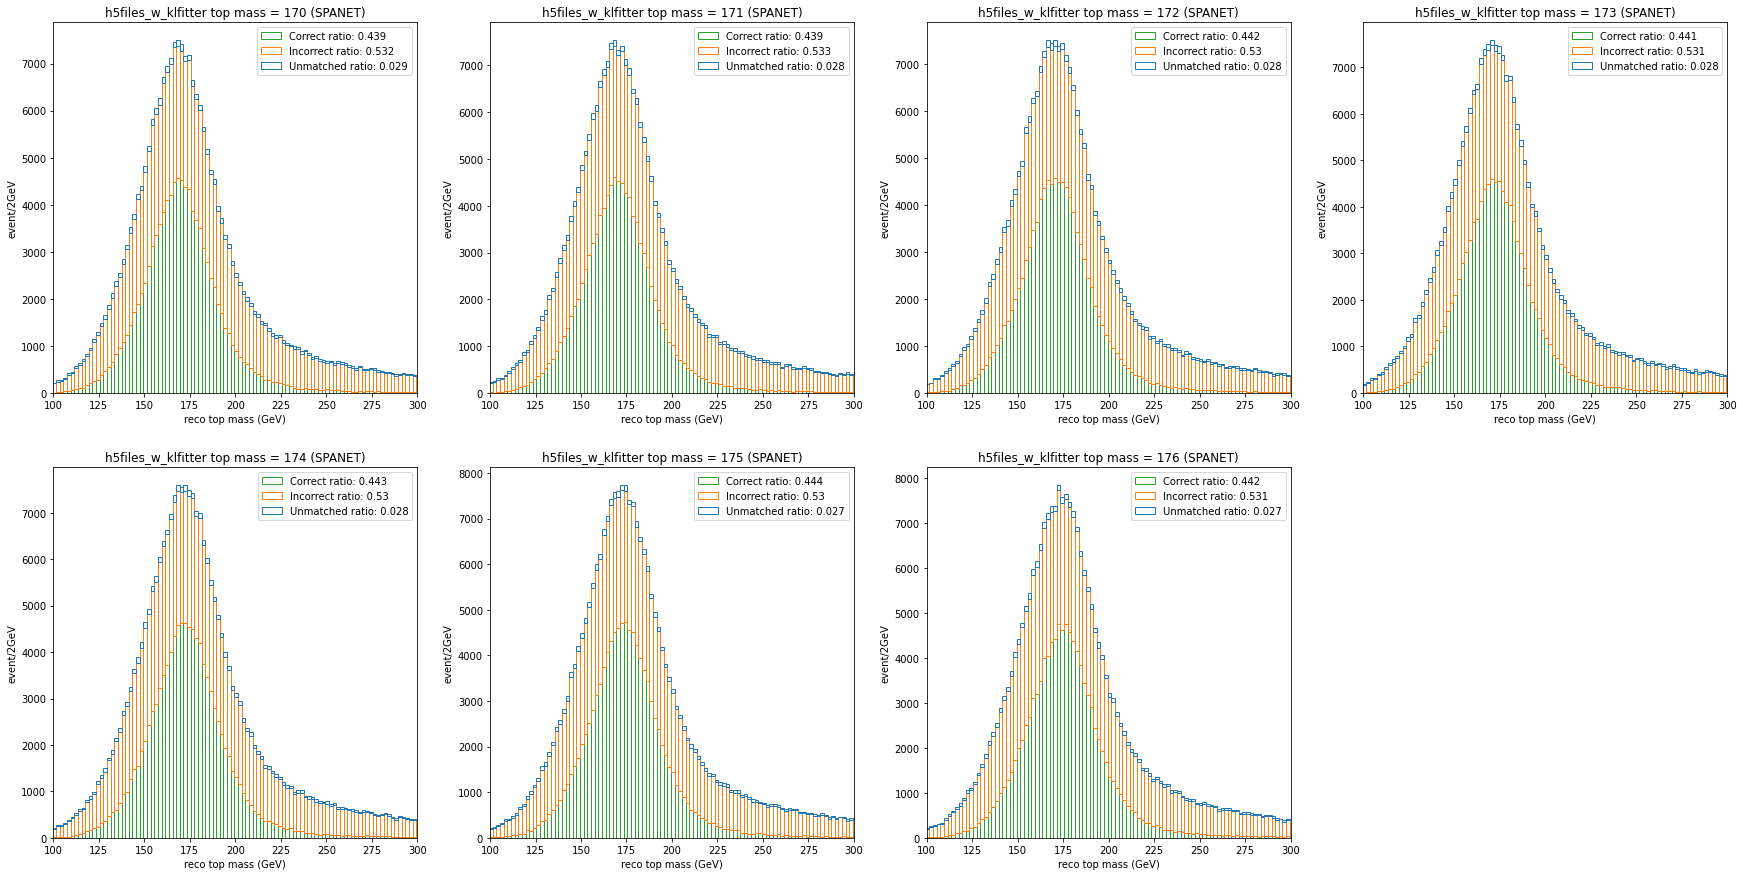

In [10]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    h = [0]*(len(bins)-1)
    
    for i in [2, 1, 0]:
        ratio = np.count_nonzero(state_spanet_dic[m]==i)/len(state_spanet_dic[m])
        hist, bin_edges = np.histogram(reco_spanet_dic[m][state_spanet_dic[m] == i], bins=bins)
        plt.bar(bin_edges[:-1]+0.5, hist, bottom=h, edgecolor=colors[i], width=2, color='None', label = state_labels[i] + ' ratio: ' + str(round(ratio, 3)))
        h += hist
    plt.title('h5files_w_klfitter top mass = {} (SPANET)'.format(m))
    plt.xlim(100, 300)
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('event/2GeV')
    plt.legend(loc='upper right')
plt.show()

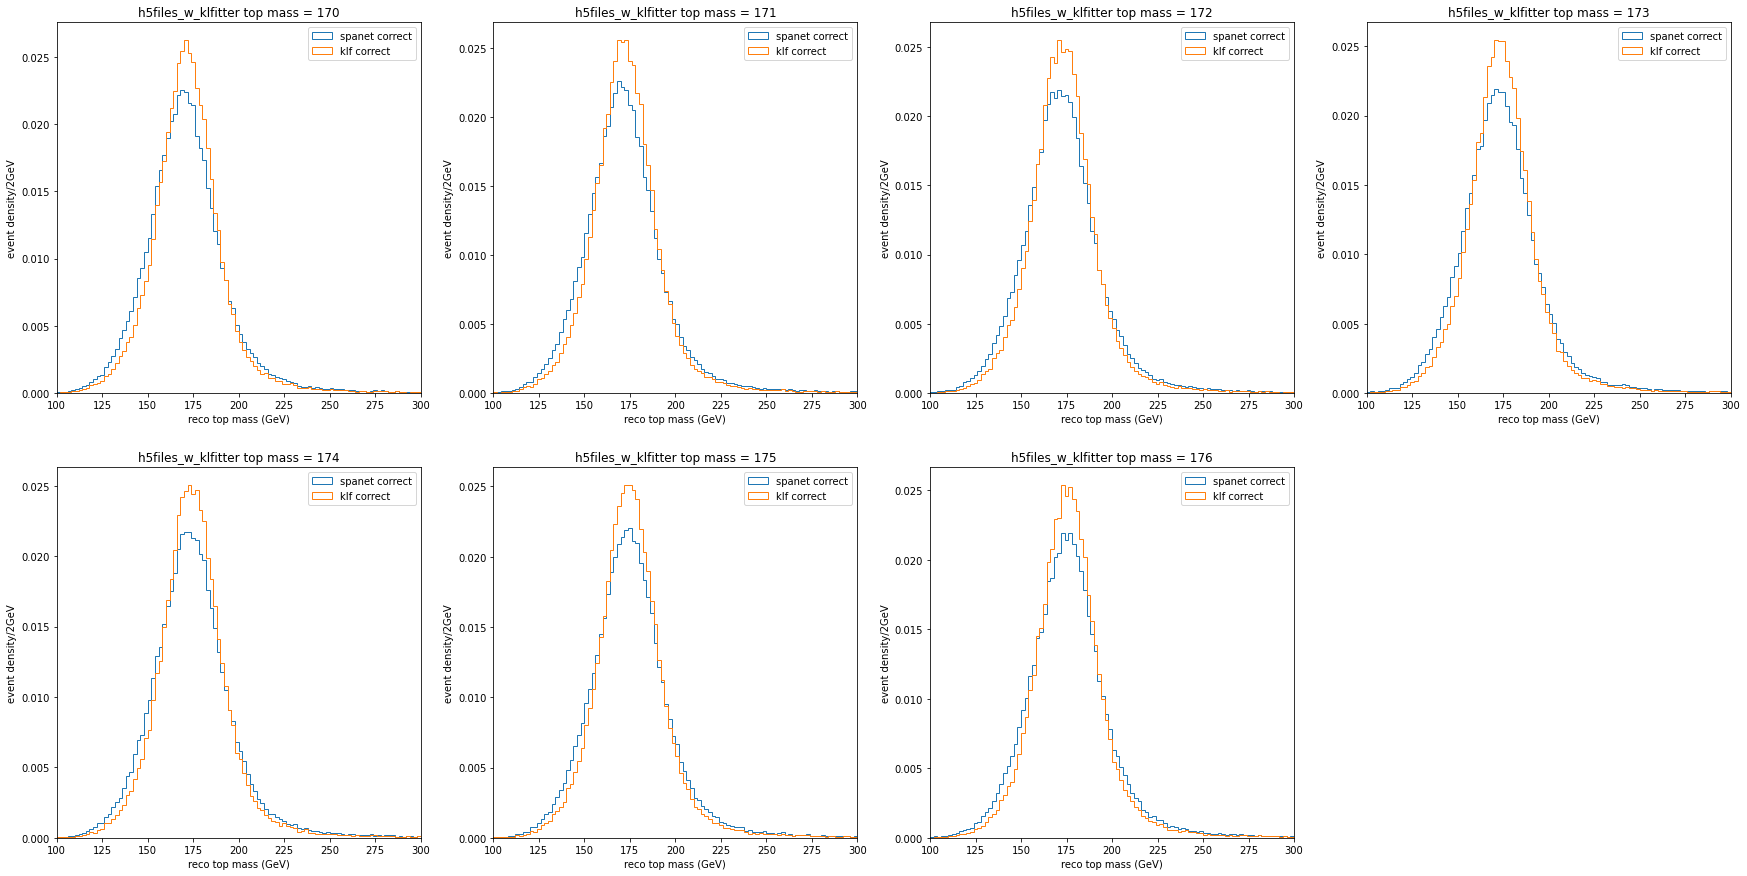

In [11]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    plt.hist(reco_spanet_dic[m][state_spanet_dic[m] == 2], bins=bins, density=True, histtype='step', label='spanet correct')
    plt.hist(reco_klf_dic[m][state_klf_dic[m] == 2], bins=bins, density=True, histtype='step', label='klf correct')
    plt.title('h5files_w_klfitter top mass = {}'.format(m))
    plt.xlim(100, 300)
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('event density/2GeV')
    plt.legend(loc='upper right')
plt.show()

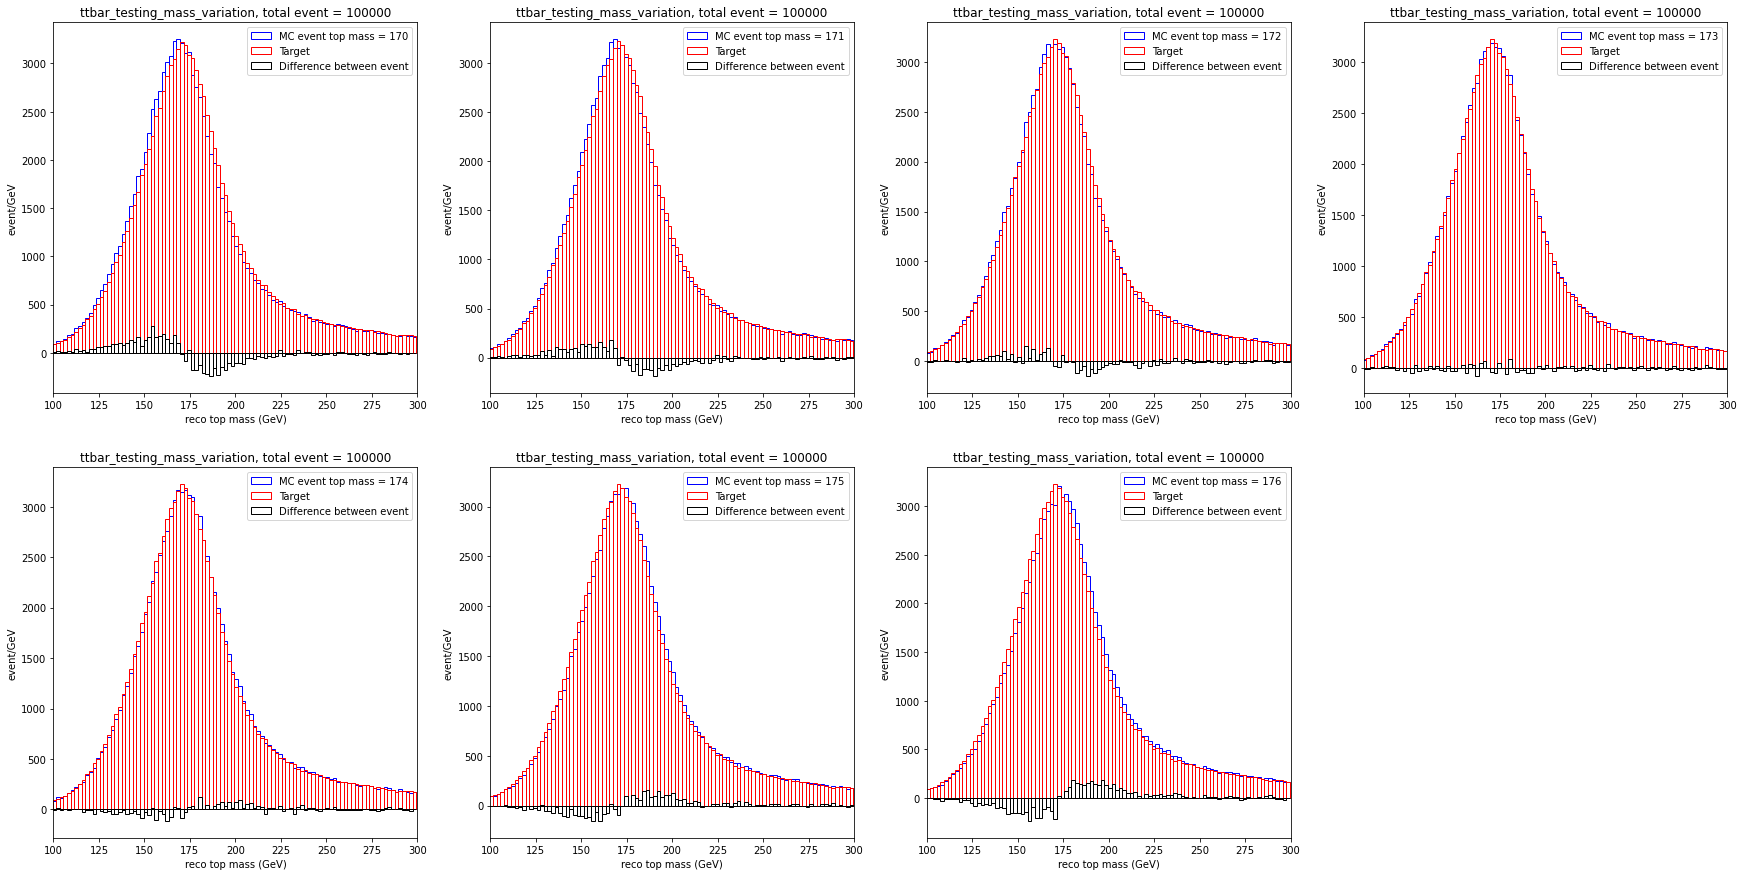

In [12]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    hist1, bin_edges = np.histogram(reco_spanet_dic[m], bins=bins)
    hist1 = hist1*tot_event/sum(hist1)
    hist2, bin_edges = np.histogram(reco_spanet, bins=bins)
    hist2 = hist2*tot_event/sum(hist2)
    plt.bar(bin_edges[:-1]+0.5, hist1, edgecolor='blue', width=2, color='None', label = 'MC event top mass = {}'.format(m))
    plt.bar(bin_edges[:-1]+0.5, hist2, edgecolor='red', width=2, color='None', label = 'Target')
    plt.bar(bin_edges[:-1]+0.5, hist1-hist2, edgecolor='black', width=2, color='None', label = 'Difference between event')
    plt.title('ttbar_testing_mass_variation, total event = {}'.format(tot_event))
    plt.xlim(100, 300)
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('event/GeV')
    plt.legend(loc='upper right')
plt.show()

In [13]:
# Sum of a Landau distribution and a gaussian distribution. Landau currently uses moyal as approximation.
# Nomalized version
def langau_norm(x, lan_loc, lan_scale, gau_loc, gau_scale, f):
    lan_y = (x-lan_loc)/lan_scale
    gau_y = (x-gau_loc)/gau_scale
    return (1-f)*np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale + f*np.exp(-gau_y**2/2)/np.sqrt(2*np.pi)/gau_scale

# Sum of a Landau distribution and a gaussian distribution. Landau currently uses moyal as approximation.
def langau(x, lan_size, lan_loc, lan_scale, gau_size, gau_loc, gau_scale):
    lan_y = (x-lan_loc)/lan_scale
    gau_y = (x-gau_loc)/gau_scale
    return lan_size*np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale + gau_size*np.exp(-gau_y**2/2)/np.sqrt(2*np.pi)/gau_scale

# Normalized landau distribution.
def lan_norm(x, lan_loc, lan_scale):
    lan_y = (x-lan_loc)/lan_scale
    return np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale

# One gaussian distribution.
def gau_norm(x, gau_loc1, gau_scale1):
    gau_y1 = (x-gau_loc1)/gau_scale1
    return np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1

# Two gaussian distributions.
def two_gau_norm(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f):
    gau_y1 = (x-gau_loc1)/gau_scale1
    gau_y2 = (x-gau_loc2)/gau_scale2
    return (1-f)*np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1 + f*np.exp(-gau_y2**2/2)/np.sqrt(2*np.pi)/gau_scale2

# Linear
def linear(x, a, b):
    return a*x+b

In [14]:
def chi2_pdf(mt1, n2): #mt1 is the observation, n2 is the height of the bins from pdf.
    n1, _ = np.histogram(mt1, bins=bins)
    n2 *= 2*len(mt1)
    chi2_value = 2*sum([n2[i] - n1[i] + n1[i]*np.log(n1[i]/n2[i]) if n1[i]!=0 else n2[i] for i in range(len(n1))])
    return chi2_value

Unmatched gau [170.20701182  46.92956978]
Unmatched lan [157.19085749  26.9422439 ]
Unmatched langau [202.09926305  25.9576776  151.96686003  25.77519673   0.54092099]


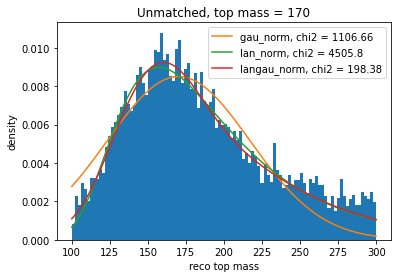

Unmatched gau [171.65718157  47.04208465]
Unmatched lan [158.63238147  26.94790192]
Unmatched langau [201.86111266  26.83815188 153.01268861  25.4807826    0.52426583]


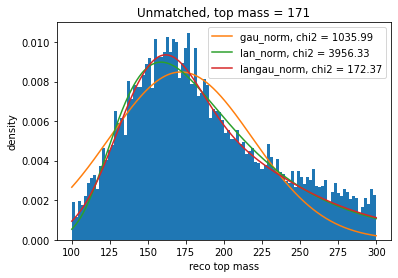

Unmatched gau [172.33668977  46.89417762]
Unmatched lan [159.13367204  26.86803895]
Unmatched langau [207.5550903   26.05575203 155.04343687  25.72324805   0.56049278]


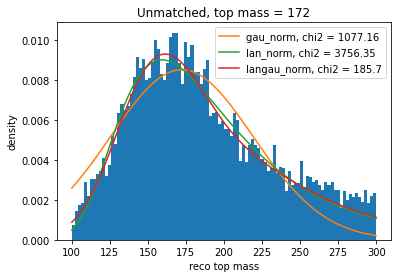

Unmatched gau [172.7278344   48.26512823]
Unmatched lan [159.09653256  27.60007385]
Unmatched langau [206.73693146  25.76939995 153.79603753  25.75432736   0.54457676]


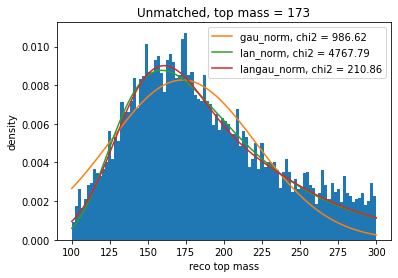

Unmatched gau [173.39733305  47.91133113]
Unmatched lan [159.78952359  27.3493502 ]
Unmatched langau [182.12354371  26.00343668 143.17270242  23.08584841   0.31474014]


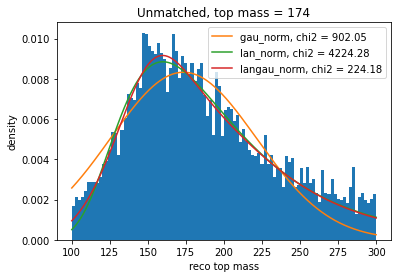

Unmatched gau [173.02511631  48.10657776]
Unmatched lan [159.38396896  27.5236077 ]
Unmatched langau [234.48585944  22.43998103 163.11674341  31.05743202   0.72238493]


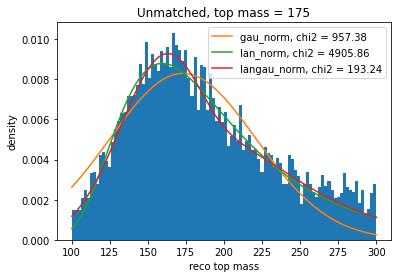

Unmatched gau [174.4195985   46.57224602]
Unmatched lan [161.22214813  27.1048626 ]
Unmatched langau [1.60997381e+02 2.95010571e+01 1.71278896e+02 1.79077770e+01
 8.61091897e-02]


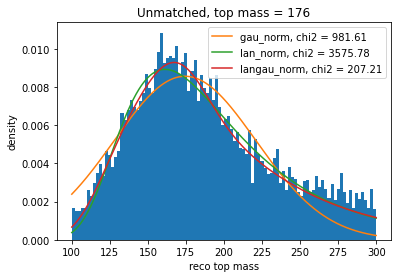

Incorrect gau [172.21752517  37.7074015 ]
Incorrect lan [161.24814233  22.60454709]
Incorrect langau [195.88794021  23.73856382 158.0374425   24.01153463   0.55635924]


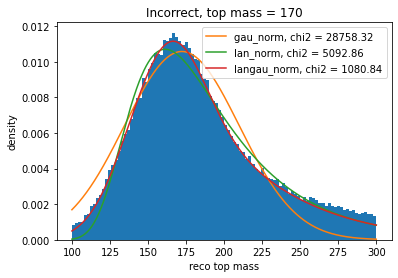

Incorrect gau [172.41308817  37.58217088]
Incorrect lan [161.49857838  22.54789124]
Incorrect langau [160.98090581  26.3825265  170.99101705  18.32078255   0.17360588]


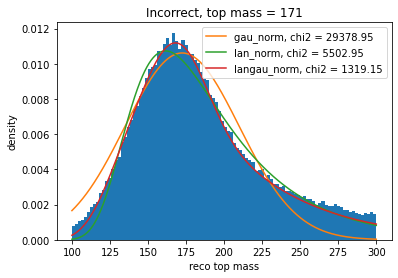

Incorrect gau [172.65305754  37.68628835]
Incorrect lan [161.64883514  22.57400949]
Incorrect langau [1.61286993e+02 2.61612572e+01 1.70942788e+02 1.81935711e+01
 1.62875222e-01]


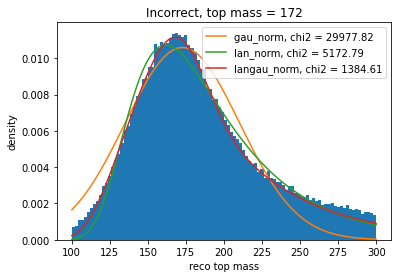

Incorrect gau [173.34577001  37.68898048]
Incorrect lan [162.41784656  22.59471599]
Incorrect langau [195.0156615   23.84422357 158.64913529  24.04827555   0.53963825]


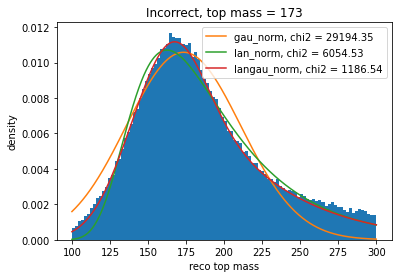

Incorrect gau [173.48947474  37.74304623]
Incorrect lan [162.47257307  22.62252712]
Incorrect langau [197.58438079  23.70085338 159.29029515  24.01224687   0.55909856]


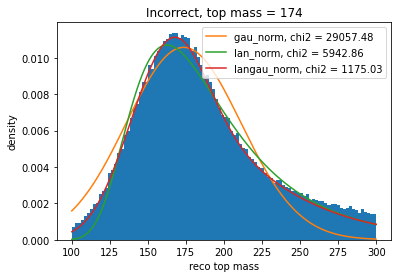

Incorrect gau [173.80565614  37.72029599]
Incorrect lan [162.85606987  22.64048092]
Incorrect langau [162.53281475  26.66575977 171.97492045  18.41249018   0.17767777]


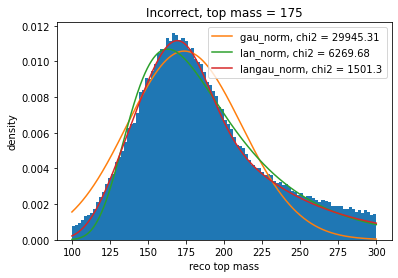

Incorrect gau [174.3168781   38.10861912]
Incorrect lan [163.19199836  22.79388547]
Incorrect langau [195.48226362  23.68279155 158.84632233  23.87210263   0.52849957]


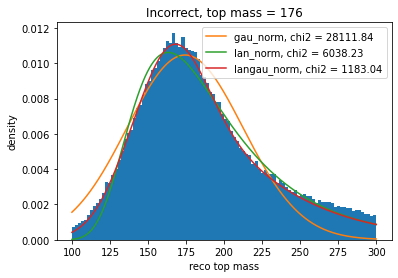

Correct gau [168.72279741  18.38873992]
Correct lan [163.20166806  11.28701401]
Correct langau [153.58283856  18.12697353 169.89912752  14.94801345   0.6873542 ]


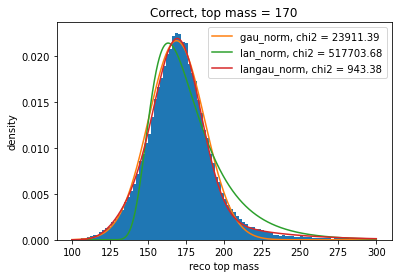

Correct gau [169.50656976  18.46226532]
Correct lan [163.93086587  11.36640089]
Correct langau [153.9782414   17.68288096 170.85522092  14.88758736   0.67588129]


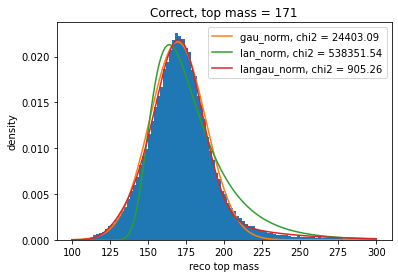

Correct gau [170.42935557  18.51623456]
Correct lan [164.90364518  11.3599232 ]
Correct langau [154.71218596  17.93919655 171.73466295  14.93130828   0.67937913]


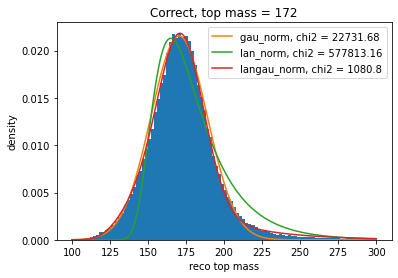

Correct gau [171.24928809  18.68161381]
Correct lan [165.59410326  11.49284256]
Correct langau [176.18968101   9.61195981 166.00455969  17.71436622   0.69316426]


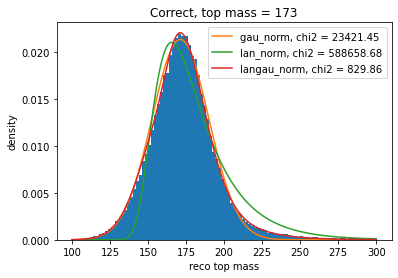

Correct gau [172.15305893  18.78024382]
Correct lan [166.4468367   11.54890275]
Correct langau [177.09879754   9.68867524 166.80058756  17.75368025   0.68866299]


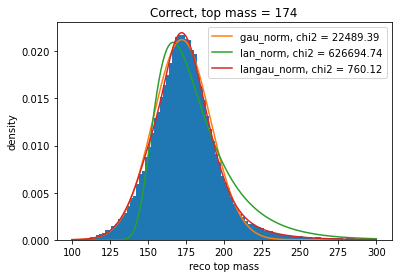

Correct gau [172.98073815  18.73124399]
Correct lan [167.34682532  11.51622248]
Correct langau [157.04182106  17.97054536 174.33982273  15.13091731   0.67938914]


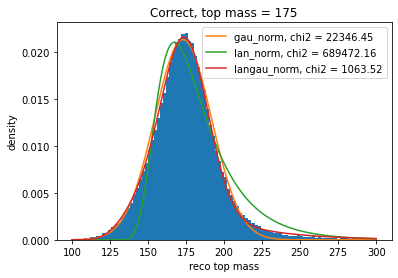

Correct gau [173.84796384  18.89750532]
Correct lan [168.12492388  11.66133277]
Correct langau [157.57838007  17.60627084 175.45087084  14.99476326   0.65757145]


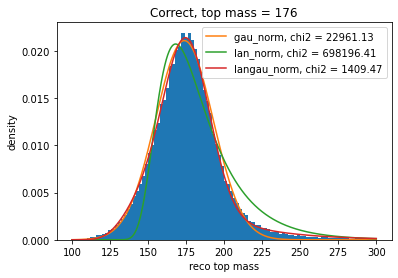

In [15]:
for state_i in [0, 1, 2]:
    for m in mass:
        hist, bin_edges = np.histogram(reco_spanet_dic[m][state_spanet_dic[m]==state_i], bins=bins, density=True)
        x = np.linspace(100, 300, 10000)

        # Fit to a Gaussian
        popt, pcov = optimize.curve_fit(gau_norm, bin_edges[:-1]+0.5, hist,
                                        p0=(150, 20), method="lm")
        y_gau_norm = gau_norm(x, popt[0], popt[1])
        print(state_labels[state_i] + ' gau', popt)
        chi_gau_norm = chi2_pdf(reco_spanet_dic[m][state_spanet_dic[m]==state_i], gau_norm(bins[:-1]+1, popt[0], popt[1]))
        
        # Fit to a landau
        popt, pcov = optimize.curve_fit(lan_norm, bin_edges[:-1]+0.5, hist,
                                        p0=(150, 20), method="lm")
        y_lan_norm = lan_norm(x, popt[0], popt[1])
        print(state_labels[state_i] + ' lan', popt)
        chi_lan_norm = chi2_pdf(reco_spanet_dic[m][state_spanet_dic[m]==1], lan_norm(bins[:-1]+1, popt[0], popt[1]))
        
        # Fit to a Langau
        popt, pcov = optimize.curve_fit(langau_norm, bin_edges[:-1]+0.5, hist,
                                        p0=(150, 20, 150, 20, 0.5), method="lm")
        print(state_labels[state_i] + ' langau', popt)
        y_langau_norm = langau_norm(x, popt[0], popt[1], popt[2], popt[3], popt[4])
        chi_langau_norm = chi2_pdf(reco_spanet_dic[m][state_spanet_dic[m]==state_i], langau_norm(bins[:-1]+1, popt[0], popt[1], popt[2], popt[3], popt[4]))

        plt.hist(reco_spanet_dic[m][state_spanet_dic[m]==state_i], bins=bins, density=True)
        plt.plot(x, y_gau_norm, label='gau_norm, chi2 = {}'.format(round(chi_gau_norm, 2)))
        plt.plot(x, y_lan_norm, label='lan_norm, chi2 = {}'.format(round(chi_lan_norm, 2)))
        plt.plot(x, y_langau_norm, label='langau_norm, chi2 = {}'.format(round(chi_langau_norm, 2)))
        plt.title(state_labels[state_i] + ', top mass = {}'.format(m))
        plt.xlabel('reco top mass')
        plt.ylabel('density')
        plt.legend(loc='upper right')
        plt.show()

In [16]:
# Fit different state to different distribution.
# Fit all to two_gau_norm
popt_arr = []
for i, m in enumerate(mass):
    hist, bin_edges = np.histogram(reco_spanet_dic[m], bins=bins, density=True)
    popt, pcov = optimize.curve_fit(two_gau_norm, bin_edges[:-1]+0.5, hist,
                                    p0=(150, 100, 100, 100, 0.9), method="lm")
    popt_arr.append(popt)

popt_arr = np.transpose(np.array(popt_arr))
all_a_arr, all_b_arr = [], []
for arr in popt_arr:
    popt, pcov = optimize.curve_fit(linear, mass, arr, method="lm")
    all_a_arr.append(popt[0])
    all_b_arr.append(popt[1])

In [17]:
# Fit unmatched to langau
popt_arr = []
for i, m in enumerate(mass):
    hist, bin_edges = np.histogram(reco_spanet_dic[m][state_dic[m]==0], bins=bins, density=True)
    popt, pcov = optimize.curve_fit(gau_norm, bin_edges[:-1]+0.5, hist,
                                    p0=(150, 100), method="lm")
    popt_arr.append(popt)
popt_arr = np.transpose(np.array(popt_arr))
unmatch_a_arr, unmatch_b_arr = [], []
for arr in popt_arr:
    popt, pcov = optimize.curve_fit(linear, mass, arr, method="lm")
    unmatch_a_arr.append(popt[0])
    unmatch_b_arr.append(popt[1])

NameError: name 'state_dic' is not defined